## Heterogeneous Treatment Effects

In the first few notebook examples, we were mostly concerned with the estimation of **average** treatment effects, in order to determine whether treatment is overall effective or not. That is totally fine from a perspective of understanding the world and how it operates under the hood. However, intuitively we know that some treated individuals won't have the same response to treatment. In fact, some individuals - regardless of being treated or not - will have a stronger response to treatment.

Hence, it makes sense for us, especially in business contexts, to find the individuals that will respond better to a given treatment, in order to leverage profitability, for instance. Also, when we determine ATE, we are talking about a population of millions of customers. Therefore, it can be unfeasible, from a budget limititation's standpoint, to treate every single customer... What we can do is find the top customers and treat them preferrably.

But how can we do that?

The anwers lies in **Machine Learning**!! We have been used to a passive approach to ML, where we simply predict most profitable customers and we stop there. However, we can leverage predictive models in a more **active approach**, in order to predict which customers should receive the treatment and then treat them in the specific business context.

In a nutshell, the question we want to answer has a slightly different form now: **Who do we treat?**

### Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import style
import matplotlib.pyplot as plt
import seaborn as sns
style.use("fivethirtyeight")

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from lightgbm import LGBMRegressor

### Data

For this dataset, `smoker` is our treatment variable, while `psyc_distress` is our outcome variable. The main idea is that we will match smokers and non-smokers according to a set of covariates, including `sex` (0: Female; 1: Male), `indigeneity` (0: Non-indigenous; 1: indigenous), `high_school` (0: not finished high school; 1: finished high school), `partnered` (0: not partnered; 1: partnered), `remoteness` (0: major cities; 1: inner regional; 2: outer regional), `language` (0: non-English speaking; 1: English speaking), `age` and `risky_alcohol` (alcohol use - 0: not risky; 1: risky).

In [2]:
df = pd.read_csv("../data/smoking_psyc_distress.csv",)
df.head()

,sex,indigeneity,high_school,partnered,remoteness,language,smoker,risky_alcohol,psyc_distress,age
0,0,0,1,1,0,1,0,0,13,63
1,0,0,1,1,0,1,0,1,11,48
2,0,0,0,0,0,1,0,1,11,54
3,1,0,1,1,0,1,0,1,12,50
4,0,0,0,1,1,1,0,1,10,67


In [3]:
df.describe()

,sex,indigeneity,high_school,partnered,remoteness,language,smoker,risky_alcohol,psyc_distress,age
count,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000
mean,0.448375,0.021750,0.61150,0.663500,0.474375,0.918500,0.121750,0.553500,15.07025,53.517375
std,0.497359,0.145875,0.48744,0.472542,0.728292,0.273619,0.327017,0.497161,5.73408,14.193762
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,10.00000,30.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,11.00000,41.000000
50%,0.000000,0.000000,1.00000,1.000000,0.000000,1.000000,0.000000,1.000000,13.00000,54.000000
75%,1.000000,0.000000,1.00000,1.000000,1.000000,1.000000,0.000000,1.000000,17.00000,66.000000
max,1.000000,1.000000,1.00000,1.000000,2.000000,1.000000,1.000000,1.000000,50.00000,79.000000


Some basic definitions:

In [4]:
Y = "psyc_distress"
T = "smoker"
X = [c for c in df.columns if not c in [Y, T]]

> Now we are going to take a look at several approaches for computing CATE

Before we proceed, let's split the dataset into a training and a test sets.

In [5]:
df_train, df_test = train_test_split(df, test_size=0.30, random_state=99)

### 1. S-Learner

This is known as the *Go-Horse Learner*, as it is indeed the simplest model we can possible come up with. The idea is to fit a model $M_{s}(X, T)$ that uses both covariates and treatment as predictors.

Then, at inference time, we get predictions while setting $T=1$ for the whole base and subtract from the predictions when setting $T=0$ for the whole base. Mathematically:

$\hat{\tau}(x)_{i} = M_{s}(X_{i}, T=1) - M_{s}(X_{i}, T=0)$

In [6]:
np.random.seed(99)
model = LGBMRegressor(max_depth=3, min_child_samples=30, random_state=99)
model.fit(df_train[X + [T]], df_train[Y])

df_s_train = df_train.assign(
    cate=(
        model.predict(df_train[X].assign(**{T: 1})) -
        model.predict(df_train[X].assign(**{T: 0}))
    )
)
df_s_test = df_test.assign(
    cate=(
        model.predict(df_test[X].assign(**{T: 1})) -
        model.predict(df_test[X].assign(**{T: 0}))
    )
)

In [7]:
df_s_test.head()

,sex,indigeneity,high_school,partnered,remoteness,language,smoker,risky_alcohol,psyc_distress,age,cate
4607,1,0,1,1,0,1,0,0,10,71,0.657327
744,0,0,1,1,0,1,0,1,12,30,2.205003
2386,0,0,0,1,1,1,0,1,10,73,1.051395
907,0,0,1,1,1,1,0,1,14,37,1.859353
3799,1,0,1,0,0,1,0,1,13,43,3.691587


Ok, we've got our predictions for CATE... The question now is: **How do we evaluate whether or not the performance is satisfactory?**

In a nutshell, what we are attempting to predict is the **elasticity** - how each individual's outcome vary when changing $T=0$ to $T=1$. Mathematically, $\frac{\delta y}{\delta T}$ is what we would like to obtain, and of course it is **unobservable**.

The main idea behind heterogeneous effects is that some individuals are more sensitive to treatment than others. Then, it makes sense to order them according to their sensitivity.

Then, we can go from the most sensitive units to the least one. Even better, we can think of a **CUMULATIVE ELASTICITY CURVE**, where at the end we will just converge to the ATE for the whole dataset.

Mathematically, we can define the cumulative elasticity as:

$(\frac{\delta y}{\delta T})_{k} = \frac{\sum_{i=1}^{k}(t_{i}-\overline{t})(y_{i} - \overline{y})}{\sum_{i=1}^{k}(t_{i}-\overline{t})^2}$

which is simply the definition of the coefficient for the treatment variable, for a simple linear regression.

Interpreting this curbe is somehow burdensome. The X axis of the curve represents how many samples are we treating. The Y axis is the elasticity we should expect at that many samples. So, if a curve has value 3 at 10%, it means that the elasticity of the top 10% units is 3. **Ideally, we strive for the highest elasticity for the largest possible sample**. An ideal curve then would start high up on the Y axis and descend very slowly to the average elasticity.

Nevertheless, we can make a tweak to this curve and improve its interpretability... Let's just multiply the sample size until that point the current cumulative elasticity. This is the so-called **CUMULATIVE GAIN CURVE**, which is conceptually very similar to a ROC when evaluating ML models - the random model will be a diagonal straight line. **The better the model at ordering elasticity, the more the curve will diverge from the random line in the points between zero and one**.

Once again, mathematically

$\hat{F(t)_{k}} = \frac{\sum_{i=1}^{k}(t_{i}-\overline{t})(y_{i} - \overline{y})}{\sum_{i=1}^{k}(t_{i}-\overline{t})^2} \frac{k}{N}$

In [9]:
cumulative_gain_eval = CumulativeGainEvaluator(
    train=df_train,
    test=df_test,
    model=model,
    outcome=Y,
    treatment=T,
    covariates=X,
    model_name="S-Learner"
)

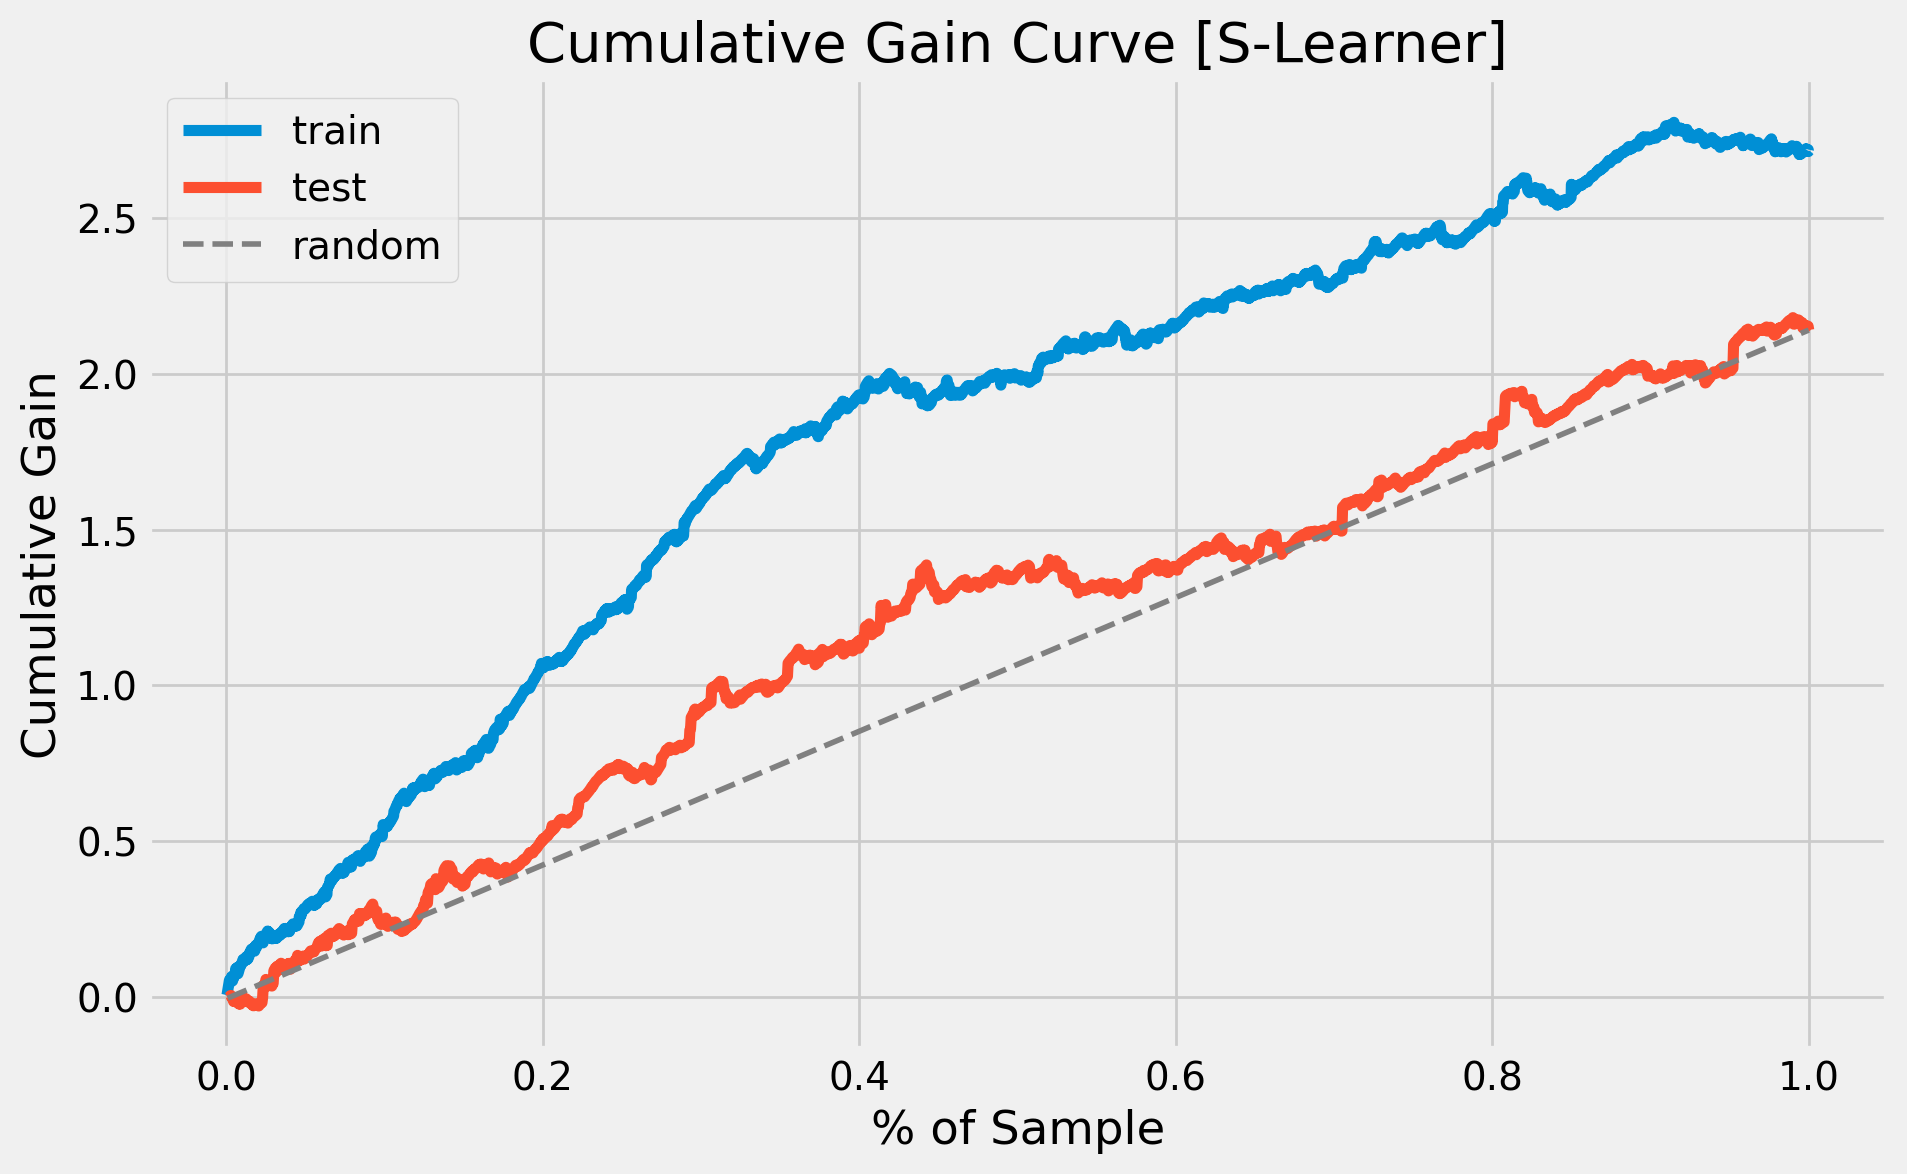

In [10]:
cumulative_gain_eval.fit()
cumulative_gain_eval.eval()